# YouTube Video Sentiment Analysis - Data Collection / Sentiment + Emotion Analysis Script

# By Aryan Shetty

# 🎬 YouTube Movie Trailer Sentiment & Emotion Analysis

## 1. Objective

The goal is to **analyze public sentiment and emotional reactions to movie trailers** using YouTube comments.

---

## 2. Data Sources

- **YouTube API**  
  Used to fetch trailer video metadata and user comments.

- **Hugging Face Pretrained Models**  
  - **Sentiment Analysis**: [`Pretrained Model for Sentiment Analysis`](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)  
  - **Emotion Recognition**: [`Pretrained Model for Emotion Recognition`](https://huggingface.co/j-hartmann/emotion-english-distilroberta-base)

---

## 3. YouTube API Setup

1. Go to [Google Cloud Console](https://console.cloud.google.com/)
2. Create a project and enable the **YouTube Data API v3**
3. Generate an API key
4. Create a `.env` file in your project folder and add:

    ```
    YOUTUBE_API_KEY=your_actual_api_key_here
    ```

5. Load it in your Python code:

    ```python
    from dotenv import load_dotenv
    import os

    load_dotenv()
    YOUTUBE_API_KEY = os.getenv("YOUTUBE_API_KEY")
    ```

---

## 4. Methodology

### 4.1 Data Collection

- Search for YouTube videos using keywords like `"Movie Name + Trailer"`
- Retrieve metadata (title, views, likes, comments)
- Collect top-level comments for each video

### 4.2 Text Preprocessing

- Lowercase conversion  
- URL and punctuation removal  
- Non-alphabetic filtering  
- Extra whitespace removal  
- Truncation to 512 tokens (for model compatibility)

### 4.3 Data Storage

- Processed comment data saved to:
    ```
    outputs/all_movie_comments_cleaned.csv
    ```
- Sentiment & emotion data saved to:
    ```
    outputs/comments_with_sentiment_emotion.csv
    outputs/movie_sentiment_emotion_summary.csv
    ```

---

## 5. ML Models

### Sentiment Analysis

- **Model**: RoBERTa  
- **Trained on**: Twitter data  
- **Classes**: Positive, Neutral, Negative  
- **Compound Score**: `positive - negative`

### Emotion Recognition

- **Model**: DistilRoBERTa  
- **Trained on**: English emotion-labeled datasets  
- **Classes**: Joy, Sadness, Anger, Fear, Surprise, Disgust, Neutral

---

## 6. Considerations

- API rate limiting handled using `time.sleep(0.5)`
- Only top-level comments are analyzed (not replies)
- Long comments are truncated at 512 tokens
- Sentiment is categorized using compound score bins
- One CSV and two visualizations are generated per movie


In [9]:
import pandas as pd
import datetime
import time
import re
import os
import torch
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from googleapiclient.discovery import build
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
# this is used to import private variables from YouTube -> you can either modify the script using your own credentials
# or create a .env with them.
from dotenv import load_dotenv
from tqdm import tqdm

import warnings
from transformers.utils import logging

# Suppress transformer-related warnings
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

# Also suppress warnings from ONNX or tokenizer loading
logging.set_verbosity_error()

In [ ]:
class YouTubeDataCollector:
    def __init__(self, api_key):
        """
        initialize the YouTube API client
        
        parameters:
        - api_key: your YouTube API key
        """
        self.youtube = build('youtube', 'v3', developerKey=api_key)

        # Use GPU if available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # initialize pretrained sentiment analysis model
        # using RoBERTa model fine-tuned for sentiment analysis on tweets
        # source: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest
        self.sentiment_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
        self.sentiment_tokenizer = AutoTokenizer.from_pretrained(self.sentiment_model_name)
        self.sentiment_model = AutoModelForSequenceClassification.from_pretrained(self.sentiment_model_name).to(self.device)

        # doing the same but for emotion analysis
        # source: https://huggingface.co/j-hartmann/emotion-english-distilroberta-base
        self.emotion_model_name = "j-hartmann/emotion-english-distilroberta-base"
        self.emotion_tokenizer = AutoTokenizer.from_pretrained(self.emotion_model_name)
        self.emotion_model = AutoModelForSequenceClassification.from_pretrained(self.emotion_model_name).to(self.device)

        # get emotion labels dynamically from the model configuration
        self.emotion_labels = [
            self.emotion_model.config.id2label[i] 
            for i in range(len(self.emotion_model.config.id2label))
        ]

        # create emotion column names
        self.emotion_columns = [f"{label.lower()}_emotion" for label in self.emotion_labels]

        # create folder for data if it doesn't exist
        if not os.path.exists('movie_data'):
            os.makedirs('movie_data')
    
    def clean_text(self, text):
        """
        clean and preprocess text data
        
        parameters:
        - text: text to clean
        
        returns:
        - cleaned text
        """
        if text is None:
            return ""
        
        # to lowercase
        text = text.lower()
        
        # remove urls
        text = re.sub(r'http\S+', '', text)
        
        # keep only letters and spaces
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def get_sentiment_scores(self, text):
        """
        calculate sentiment scores for a given text using the pretrained model
        
        parameters:
        - text: text to analyze
        
        returns:
        - dictionary with sentiment scores
        """
        if not text:
            # return neutral sentiment if text is empty
            return {
                'compound': 0,
                'pos': 0,
                'neu': 1,
                'neg': 0
            }
        
        # truncate text if it's too long for the model
        max_length = 512
        if len(text) > max_length:
            text = text[:max_length]
        
        encoded_input = self.sentiment_tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(self.device)

        # get model output
        with torch.no_grad():
            output = self.sentiment_model(**encoded_input)
        
        # get probabilities
        scores = softmax(output.logits[0].cpu().numpy())
        
        # map scores to sentiment categories (negative, neutral, positive)
        sentiment_scores = {
            'neg': float(scores[0]),
            'neu': float(scores[1]),
            'pos': float(scores[2]),
            'compound': float(scores[2] - scores[0])
        }
        
        return sentiment_scores
    
    def get_emotion_scores(self, text):
        """
        calculate emotion scores
        
        parameters:
        - text: text to analyze
        
        returns:
        - dictionary with emotion scores
        """
        if not text:
            # return neutral emotion scores if text is empty
            return {label.lower(): 0 for label in self.emotion_labels}
        
        # truncate text if it's too long for the model
        max_length = 512
        if len(text) > max_length:
            text = text[:max_length]
        
        encoded_input = self.emotion_tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(self.device)

        # get model output
        with torch.no_grad():
            output = self.emotion_model(**encoded_input)
        
        # get probabilities
        scores = softmax(output.logits[0].cpu().numpy())
        
        # map scores to emotion categories dynamically
        emotion_mapping = {
            self.emotion_model.config.id2label[i].lower(): float(scores[i]) 
            for i in range(len(self.emotion_labels))
        }
        
        return emotion_mapping
    
    def search_videos(self, search_term, max_results=10):
        """
        search for videos related to a given term
        
        parameters:
        - search_term: term to search for
        - max_results: maximum number of videos to retrieve
        
        returns:
        - list of video IDs
        """
        search_response = self.youtube.search().list(
            q=search_term,
            part='id',
            maxResults=max_results,
            type='video',
            relevanceLanguage='en',
            order='relevance'
        ).execute()
        
        video_ids = [item['id']['videoId'] for item in search_response.get('items', [])]
        return video_ids
        
        
    
    def get_video_comments(self, video_id, movie_title, max_comments=100):
        """
        get comments for a specific video
        
        parameters:
        - video_id: ID of the video
        - max_comments: maximum number of comments to retrieve
        
        returns:
        - list of comments
        """
        comments = []
        next_page_token = None
        
        try:
            while len(comments) < max_comments:
                # request comment threads
                request = self.youtube.commentThreads().list(
                    part='snippet',
                    videoId=video_id,
                    maxResults=min(100, max_comments - len(comments)),
                    pageToken=next_page_token,
                    textFormat='plainText'
                )
                
                response = request.execute()
                
                # process comment threads
                for item in response['items']:
                    comment = item['snippet']['topLevelComment']['snippet']
                    
                    # get comment data
                    comment_data = {
                        'movie_title': movie_title,
                        'id': item['id'],
                        'text': comment['textDisplay'],
                        'author': comment['authorDisplayName'],
                        'published_at': comment['publishedAt'],
                        'like_count': comment['likeCount'],
                        'video_id': video_id
                    }
                    
                    comments.append(comment_data)
                
                # check for next page
                next_page_token = response.get('nextPageToken')
                if not next_page_token or len(comments) >= max_comments:
                    break
                
                # sleep to avoid rate limits
                time.sleep(0.5)

        except Exception as e:
            print(f"Error collecting comments for video {video_id}: {e}")
        
        return comments
    
    def collect_youtube_data(self, movie_title, max_videos=5, max_comments_per_video=100):
        """
        collect YouTube data for a specific movie
        
        parameters:
        - movie_title: title of the movie
        - max_videos: maximum number of videos to analyze
        - max_comments_per_video: maximum number of comments to retrieve per video
        
        returns:
        - list of collected comments
        """

        # search for videos
        search_term = movie_title + " trailer"
        video_ids = self.search_videos(search_term, max_results=max_videos)
        
        # collect comments for each video
        all_comments = []
        total_comments = 0
        
        for video_id in video_ids:
            print(f"Collecting comments for video: {movie_title} (video ID: {video_id})")
            
            # get comments
            video_comments = self.get_video_comments(video_id, movie_title, max_comments=max_comments_per_video)
        
            all_comments.extend(video_comments)
            total_comments += len(video_comments)
            
            # sleep to avoid rate limits
            time.sleep(0.5)
        
        print(f"Finished collecting {total_comments} comments for {movie_title}")
        
        return all_comments
    
    def add_sentiment_and_emotion(self, data, batch_size=1000):
        """
        compute sentiment and emotion scores

        Parameters:
        - data: DataFrame with a 'text' column
        - batch_size: Number of comments to process per batch

        Returns:
        - DataFrame with sentiment and emotion scores
        """
        sentiment_results = []
        emotion_results = []

        for i in tqdm(range(0, len(data), batch_size), desc="Analyzing sentiment/emotion", ncols=100):
            batch = data['text'].iloc[i:i+batch_size]

            for comment_text in batch:
                # clean the comment
                cleaned_text = self.clean_text(comment_text if isinstance(comment_text, str) else "")

                # sentiment scores
                sentiment_scores = self.get_sentiment_scores(cleaned_text)

                # emotion scores
                emotion_scores = self.get_emotion_scores(cleaned_text)

                sentiment_results.append(sentiment_scores)
                emotion_results.append(emotion_scores)

        sentiment_df = pd.DataFrame(sentiment_results)
        emotion_df = pd.DataFrame(emotion_results)

        return pd.concat([data.reset_index(drop=True), sentiment_df, emotion_df], axis=1)
    
    
    def analyze_sentiment_and_emotion_distribution(self, data, by_movie=True):
        """
        analyze the sentiment and emotion distribution of collected data.

        Parameters:
        - data: DataFrame with collected YouTube comments and sentiment/emotion scores
        - by_movie: If True, perform analysis separately for each movie

        Returns:
        - dataFrame with one row per movie
        """
        if by_movie:
            summary_rows = []
            for movie in data['movie_title'].unique():
                movie_data = data[data['movie_title'] == movie]
                movie_summary = self.analyze_sentiment_and_emotion_distribution(movie_data, by_movie=False)
                movie_summary['movie_title'] = movie
                summary_rows.append(movie_summary)
            return pd.DataFrame(summary_rows)

        row = {}

        # sentiment averages
        row['avg_compound'] = data['compound'].mean()
        row['avg_positive'] = data['pos'].mean()
        row['avg_neutral'] = data['neu'].mean()
        row['avg_negative'] = data['neg'].mean()

        # emotion averages
        emotion_columns = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
        for col in emotion_columns:
            row[f'avg_{col}'] = data[col].mean()

        return row

In [ ]:
import glob

# load environment variables
load_dotenv()

# load all API keys
api_keys = os.getenv("YOUTUBE_API_KEYS").split(',')

# read the 1000 movie titles
movies_df = pd.read_csv('tmdb_1000_sample.csv')
movies = movies_df['title'].tolist()

# parameters
batch_size = 50
movies_per_key = 50
os.makedirs('outputs/batches_final', exist_ok=True)

# initialize
all_comments = []
batch_number = 1
api_key_index = 0

progress_file = 'outputs/progress_final.txt'

# check if progress file exists
if os.path.exists(progress_file):
    with open(progress_file, 'r') as f:
        start_idx = int(f.read().strip()) + 1  # +1 to move to next movie
    print(f"Resuming from movie index {start_idx} ({movies[start_idx]})")
else:
    start_idx = 0
    print("Starting from the beginning...")

# initialize YouTubeDataCollector with first API key
collector = YouTubeDataCollector(api_keys[api_key_index].strip())

# collect comments
for idx in range(start_idx, len(movies)):
    movie = movies[idx]
    try:
        # switch API key every 'movies_per_key' movies
        if idx != 0 and idx % movies_per_key == 0:
            api_key_index += 1
            if api_key_index >= len(api_keys):
                print("Ran out of API keys! Stopping early...")
                break
            collector = YouTubeDataCollector(api_keys[api_key_index].strip())
            print(f"Switched to API key {api_key_index + 1}")

        search_term = movie + " trailer"

        # collect comments
        movie_comments = collector.collect_youtube_data(
            movie,
            max_videos=3,
            max_comments_per_video=50
        )

        # convert to DataFrame
        movie_comments_df = pd.DataFrame(movie_comments)

        # add movie title
        movie_comments_df['movie_title'] = movie

        all_comments.append(movie_comments_df)

        # save progress
        with open(progress_file, 'w') as f:
            f.write(str(idx))

        # save batch every 'batch_size' movies
        if (idx + 1) % batch_size == 0 or (idx + 1) == len(movies):
            combined_batch = pd.concat(all_comments, ignore_index=True)
            combined_batch.to_csv(f"outputs/batches_final/movie_comments_batch_{batch_number}.csv", index=False)
            print(f"Saved batch {batch_number} after {idx + 1} movies")

            # reset for next batch
            all_comments = []
            batch_number += 1

    except Exception as e:
        print(f"Failed for {movie}: {e}")

# merge all batches at the end
batch_files = glob.glob('outputs/batches_final/*.csv')
final_comments = pd.concat([pd.read_csv(batch) for batch in batch_files], ignore_index=True)

# save final merged CSV
final_comments.to_csv('outputs/all_movie_comments_final.csv', index=False)
print("\nSaved final merged comments to outputs/all_movie_comments_final.csv")


In [ ]:
# load the merged dataset
df = pd.read_csv('outputs/all_movie_comments_final.csv')

# drop rows with missing or empty comments
df = df[df['text'].notna() & (df['text'].str.strip() != '')]

# drop rows with missing video ID or movie title if any
df = df[df['video_id'].notna() & df['movie_title'].notna()]

# reset index after filtering
df = df.reset_index(drop=True)

# save cleaned version
df.to_csv('outputs/all_movie_comments_cleaned.csv', index=False)

# preview cleaned data
df.head()


,movie_title,id,text,author,published_at,like_count,video_id
0,Avengers: Endgame,UgwIMlqwzfbht8v2Qs54AaABAg,Best best and best.,@ARBCinemaWorld,2025-04-29T23:34:15Z,0.0,TcMBFSGVi1c
1,Avengers: Endgame,Ugwmp8Xm2CXIfR6llqJ4AaABAg,Watch in 2025,@mahmoudebaid7690,2025-04-29T20:59:53Z,0.0,TcMBFSGVi1c
2,Avengers: Endgame,UgyJ9wcPkOpFjYF2A5h4AaABAg,Anyone in may 2025?,@mauriciopercastegui,2025-04-29T18:55:13Z,2.0,TcMBFSGVi1c
3,Avengers: Endgame,UgwDEkn5Pfs_58vch4h4AaABAg,Anyone in april 2025?,@mauriciopercastegui,2025-04-29T18:55:01Z,1.0,TcMBFSGVi1c
4,Avengers: Endgame,Ugwn74jeAzVdmvWn1754AaABAg,"WE ARE SO BACK, RDJ, the hero, now back as the...",@RedwanMojaddedi,2025-04-29T17:46:40Z,0.0,TcMBFSGVi1c


In [ ]:
# reload environment variables
load_dotenv()

# re-initialize collector with the first API key
api_keys = os.getenv("YOUTUBE_API_KEYS").split(',')
collector = YouTubeDataCollector(api_keys[0].strip())

# perform sentiment & emotion analysis on cleaned data
comments_with_scores = collector.add_sentiment_and_emotion(df)

# save per-comment sentiment/emotion results
comments_with_scores.to_csv('outputs/comments_with_sentiment_emotion.csv', index=False)
print("\nSaved detailed comment-level sentiment/emotion data to outputs/comments_with_sentiment_emotion.csv")

Analyzing sentiment/emotion: 100%|████████████████████████████████| 117/117 [28:48<00:00, 14.78s/it]



Saved detailed comment-level sentiment/emotion data to outputs/comments_with_sentiment_emotion.csv


In [ ]:
# load previously saved sentiment/emotion data
comments_with_scores = pd.read_csv('outputs/comments_with_sentiment_emotion.csv')

# generate movie-level summary
summary_df = collector.analyze_sentiment_and_emotion_distribution(comments_with_scores, by_movie=True)

# reorder columns to make movie_title the first
cols = summary_df.columns.tolist()
cols = ['movie_title'] + [col for col in cols if col != 'movie_title']
summary_df = summary_df[cols]

# save to CSV
summary_df.to_csv('outputs/movie_sentiment_emotion_summary.csv', index=False)
print("Saved movie sentiment/emotion summary to outputs/movie_sentiment_emotion_summary.csv")

Saved movie sentiment/emotion summary to outputs/movie_sentiment_emotion_summary.csv


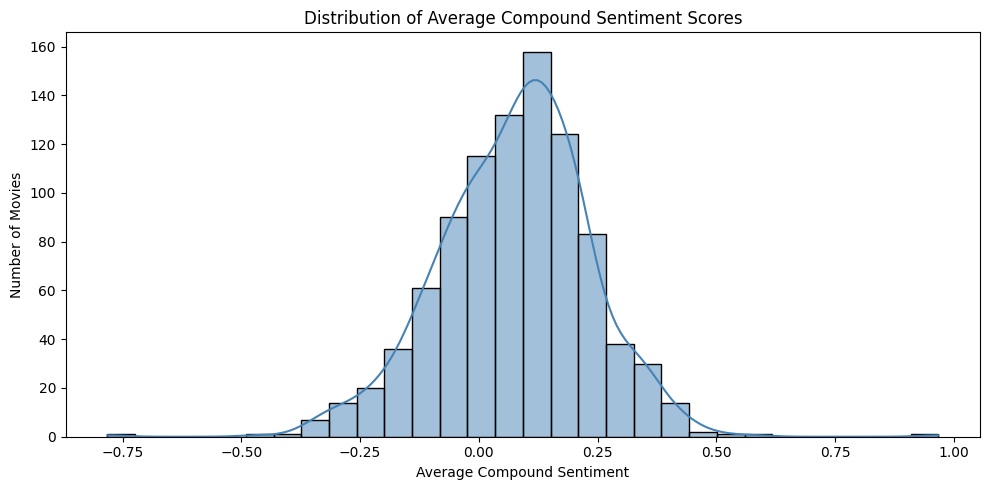

In [ ]:
# load the movie-level sentiment summary
df = pd.read_csv('outputs/movie_sentiment_emotion_summary.csv')

plt.figure(figsize=(10, 5))
sns.histplot(df['avg_compound'], bins=30, kde=True, color='steelblue')
plt.title('Distribution of Average Compound Sentiment Scores')
plt.xlabel('Average Compound Sentiment')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()

C:\Users\AryanPC\AppData\Local\Temp\ipykernel_23100\4182988388.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_positive, y='movie_title', x='avg_positive', palette='Greens_d')


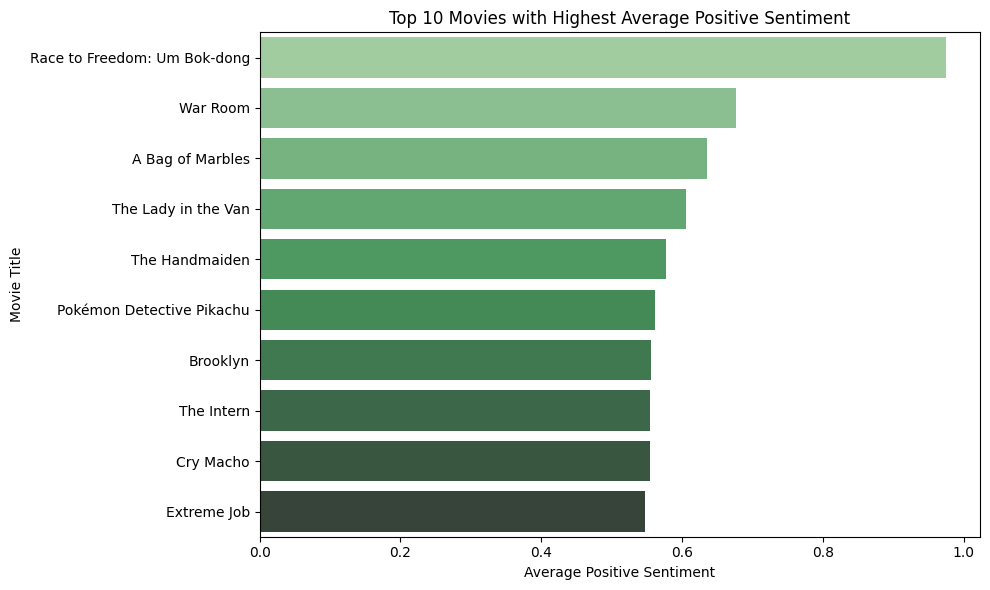

In [ ]:
# sort and select top 10
top_positive = df.sort_values('avg_positive', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_positive, y='movie_title', x='avg_positive', palette='Greens_d')
plt.title('Top 10 Movies with Highest Average Positive Sentiment')
plt.xlabel('Average Positive Sentiment')
plt.ylabel('Movie Title')
plt.tight_layout()
plt.show()


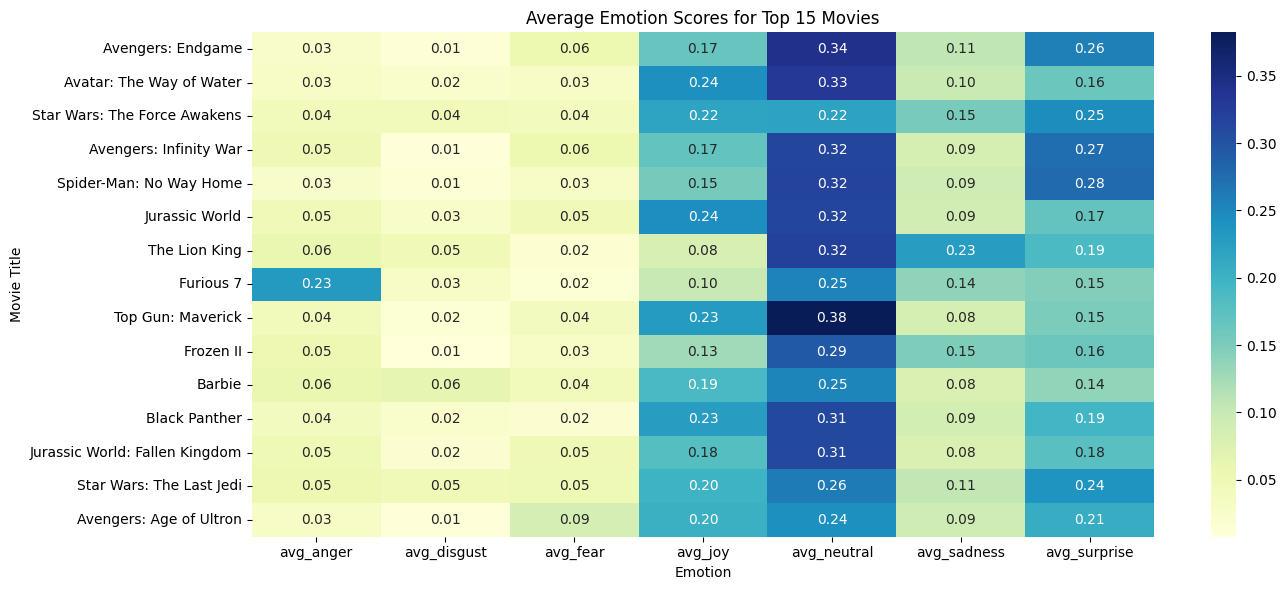

In [ ]:
# emotion columns
emotion_cols = ['avg_anger', 'avg_disgust', 'avg_fear', 'avg_joy', 'avg_neutral', 'avg_sadness', 'avg_surprise']
heatmap_df = df[['movie_title'] + emotion_cols].dropna().set_index('movie_title')
heatmap_df = heatmap_df.head(15)  # Top 15 for readability

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Average Emotion Scores for Top 15 Movies')
plt.xlabel('Emotion')
plt.ylabel('Movie Title')
plt.tight_layout()
plt.show()
